In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd


In [2]:
# Set random seed for reproducibility
np.random.seed(42)
generator = torch.Generator().manual_seed(42)

transform = transforms.Compose([
    transforms.RandomResizedCrop(32),  # Resize to 32x32 pixels directly
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])



In [3]:
# Define Hyperparameters
input_size = 32 * 32  # Size of image
num_classes = 4  # The number of distinct classes in the dataset
num_epochs = 20  # Number of epochs for training
batch_size = 64  # Batch size
learning_rate = 0.001  # Learning rate
num_hidden = 256  # Number of units in the hidden layer

In [4]:
# Load dataset and create DataLoader
full_dataset = torchvision.datasets.ImageFolder(root='../data', transform=transform)  # Load dataset from specified path
train_size = int(len(full_dataset) * 0.75)  # 75% of the data for training
test_size = len(full_dataset) - train_size  # 25% of the data for testing
train_set, test_set = random_split(full_dataset, [train_size, test_size], generator=generator)  # Split dataset
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)  # DataLoader for training set
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)  # DataLoader for test set

print(f"Total dataset size: {len(full_dataset)}, Training set size: {train_size}, Test set size: {test_size}, No. of Labels: {len(train_set.dataset.classes)}")


Total dataset size: 7083, Training set size: 5312, Test set size: 1771, No. of Labels: 4


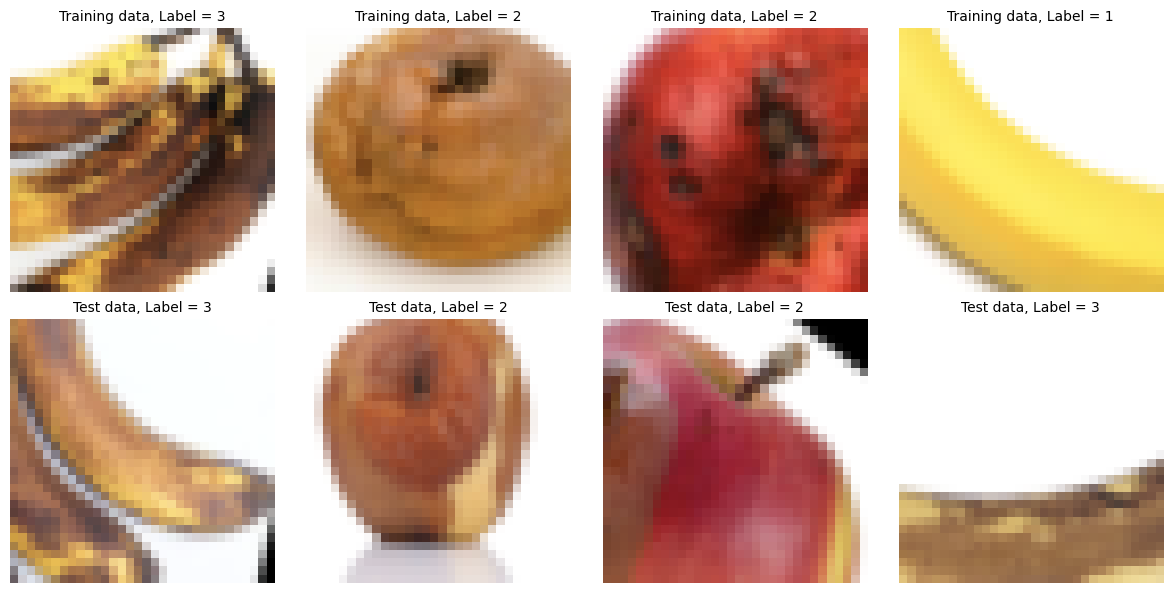

In [6]:
# Randomly select 4 samples from training and 4 from test sets
train_indices = torch.randperm(len(train_set), generator=generator)[:4]  
test_indices = torch.randperm(len(test_set), generator=generator)[:4]  

fig, axs = plt.subplots(2, 4, figsize=(12, 6))  # Create a 2x4 subplot for visualization

# Plot samples from training set
for i, idx in enumerate(train_indices):
    image, label = train_set[idx]  # Get image and label from training set
    axs[0, i].imshow(image.permute(1, 2, 0).numpy())  # Permute dimensions to (H, W, C) for plotting
    axs[0, i].set_title(f'Training data, Label = {label}', fontsize=10)  # Set title with label
    axs[0, i].axis('off')  # Hide axis ticks

# Plot samples from test set
for i, idx in enumerate(test_indices):
    image, label = test_set[idx]  # Get image and label from test set
    axs[1, i].imshow(image.permute(1, 2, 0).numpy())  # Permute dimensions to (H, W, C) for plotting
    axs[1, i].set_title(f'Test data, Label = {label}', fontsize=10)  # Set title with label
    axs[1, i].axis('off')  # Hide axis ticks

plt.tight_layout()  # Adjust layout for better display
plt.show()  # Display the figure


In [6]:
# CNN Model Architecture
class FruitClassifierCNN(nn.Module):
    def __init__(self, num_classes=12):
        super(FruitClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Second convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Third convolutional layer
        self.fc1 = nn.Linear(128 * 4 * 4, num_hidden)  # Fully connected layer, adjust dimensions based on final feature map size
        self.fc2 = nn.Linear(num_hidden, num_classes)  # Output layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling layer
        self.dropout = nn.Dropout(0.5)  # Dropout layer to prevent overfitting

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply first convolution, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply second convolution, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv3(x)))  # Apply third convolution, ReLU activation, and pooling
        x = x.view(-1, 128 * 4 * 4)  # Flatten the tensor for fully connected layers
        x = F.relu(self.fc1(x))  # Apply first fully connected layer with ReLU activation
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Output layer
        return x


In [7]:
# Device conmfiguration
device = torch.device('mps')

# Initialize the model, define loss and optimizer
model = FruitClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer


In [8]:
# Dictionary to store training progress
training_progress = {'epoch': [], 'loss': [], 'accuracy': []}

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)  # Move images to device
        labels = labels.to(device)  # Move labels to device
        
        # Forward pass
        outputs = model(images)  # Get model predictions
        cost = criterion(outputs, labels)  # Calculate the loss
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradient buffers
        cost.backward()  # Backpropagate the loss
        optimizer.step()  # Update the model parameters
        
        running_loss += cost.item()  # Accumulate the loss
        # Print loss for every 100 steps
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, len(train_loader), cost.item()))
    
    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)

    # Run Testing after each epoch
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        total = 0
        accurate = 0
        
        for images, labels in test_loader:
            images = images.to(device)  # Move images to device
            labels = labels.to(device)  # Move labels to device
            outputs = model(images)  # Get model predictions
            _, predicted = torch.max(outputs, 1)  # Get the predicted class with the highest score
            total += labels.size(0)  # Total number of labels
            accurate += (predicted == labels).sum().item()  # Count number of correct predictions
        
        accuracy_score = 100 * accurate / total  # Calculate accuracy
        print('==> Epoch: {0}, test accuracy = {1:.3f}'.format(epoch + 1, accuracy_score))
    
    # Save epoch, loss, and accuracy to the dictionary
    training_progress['epoch'].append(epoch + 1)
    training_progress['loss'].append(avg_loss)
    training_progress['accuracy'].append(accuracy_score)

print('Final Accuracy = {0:.2f}%'.format(accuracy_score))  # Print final accuracy


==> Epoch: 1, test accuracy = 76.100
==> Epoch: 2, test accuracy = 86.343
==> Epoch: 3, test accuracy = 87.674
==> Epoch: 4, test accuracy = 88.137
==> Epoch: 5, test accuracy = 90.914
==> Epoch: 6, test accuracy = 91.088
==> Epoch: 7, test accuracy = 91.319
==> Epoch: 8, test accuracy = 90.336
==> Epoch: 9, test accuracy = 90.683
==> Epoch: 10, test accuracy = 90.972
==> Epoch: 11, test accuracy = 90.394
==> Epoch: 12, test accuracy = 92.998
==> Epoch: 13, test accuracy = 92.072
==> Epoch: 14, test accuracy = 92.130
==> Epoch: 15, test accuracy = 90.799
==> Epoch: 16, test accuracy = 91.146
==> Epoch: 17, test accuracy = 93.981
==> Epoch: 18, test accuracy = 93.345
==> Epoch: 19, test accuracy = 92.650
==> Epoch: 20, test accuracy = 92.014
Final Accuracy = 92.01%


In [ ]:
# Save training progress  to a CSV file
training_progress_df = pd.DataFrame(training_progress)
training_progress_df.to_csv('../code/training_progress_no_preprocessing.csv', index=False)

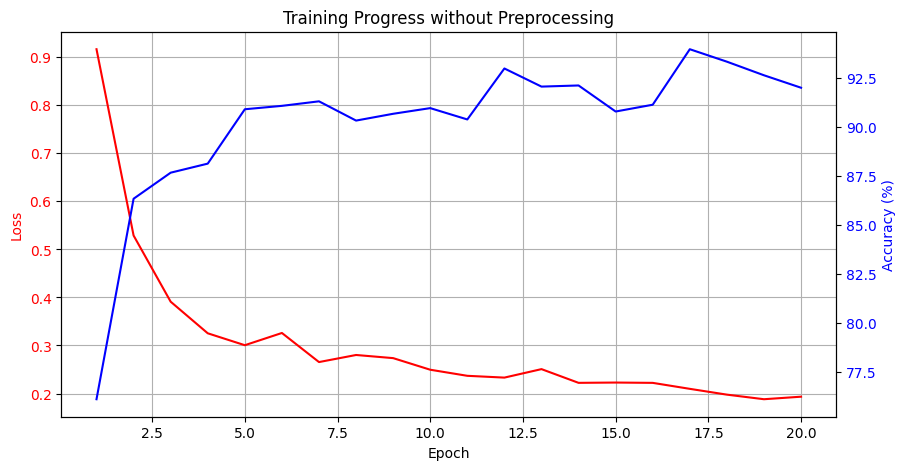

In [13]:
# Read the CSV file
training_progress_df = pd.read_csv('../code/training_progress_no_preprocessing.csv')

# Plot the training progress
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot loss on the first y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='red')
ax1.plot(training_progress_df['epoch'], training_progress_df['loss'], color='red', label='Training Loss')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy (%)', color='blue')
ax2.plot(training_progress_df['epoch'], training_progress_df['accuracy'], color='blue', label='Training Accuracy')
ax2.tick_params(axis='y', labelcolor='blue')

# Add title and grid
plt.title('Training Progress without Preprocessing')
ax1.grid()

# Display plot
plt.show()
